In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pybaseball as pyb
import sklearn as scikit_learn 

In [12]:
# look up a player's id with text input

name = input()
name_split = name.split(" ")
first, last = name_split[0], name_split[1]

x = pyb.playerid_lookup(last, first)
print(x['key_mlbam'][0])

665833


In [ ]:
data = pyb.statcast_pitcher('2024-04-10', '2024-08-19', player_id= 506433)
print(data.columns)

In [9]:
data = pyb.statcast_single_game(529429)
data.to_csv('test')

In [44]:
# importing model and cleaning

data = pyb.statcast('2024-03-28', '2024-03-29')
# release_speed, pfx_x, pfx_z, release_spin_rate
# pitch_name, spin_axis (affected by p_throws)

# return pitch_name

# cleaning up data
pitch_parameters = [
    'pitch_name', 
    'release_speed', 
    'pfx_x', 'pfx_z', 
    'release_spin_rate', 
    'spin_axis', 
    'p_throws'
]

data = data[pitch_parameters]

# cleaning up pitch_name 
excluded_values = [
    'Pitch Out', 
    'Other', 
    'Eephus', 
    'Slurve'
]
data = data[~data['pitch_name'].isin(excluded_values)]

# removing na values in pitch_name
data.dropna(subset=['pitch_name'], inplace=True)
data = data.dropna()

# converting movement to inches
data['pfx_x'] = data['pfx_x'] * 12
data['pfx_z'] = data['pfx_z'] * 12 

data.shape

This is a large query, it may take a moment to complete


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


(6363, 7)

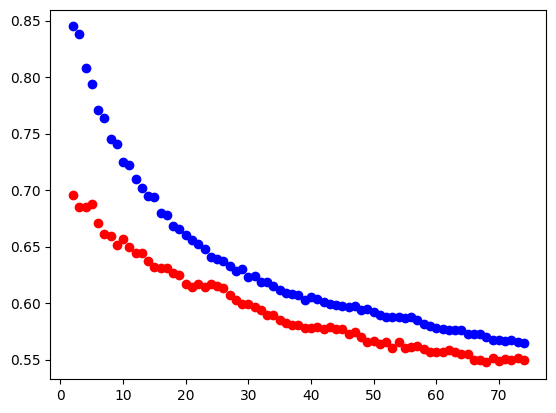

In [50]:
# KNN 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


# changing p_throws to a numerical value by mapping and replacing
pitching_hand = {'R':0, 'L':1}
data['p_throws'] = data['p_throws'].replace(pitching_hand)

# apparently good practice to check data types 
# data.dtypes

# splitting data    
x_data_split = [
    'release_speed', 
    'pfx_x', 'pfx_z', 
    'release_spin_rate', 
    'spin_axis', 
    'p_throws'
]

X = data[x_data_split]
y = data['pitch_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# training the model
K, training, test, scores = [], [], [], {}

for k in range(2, 75):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)

    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    K.append(k)
    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]

plt.scatter(K, training, c='blue')
plt.scatter(K, test, c='red')
plt.show()

In [52]:
# the model sucked in its first iteration

# making sure that this model really sucks and basically confirming skill issue
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5)
scores

# returns close to 50% which basically means this model is guessing
# might be because there's too many pitch types

array([0.47682639, 0.49646504, 0.54438335, 0.43474843, 0.53694969])

In [ ]:
# Decision Tree